In [1]:
import numpy as np
import matplotlib.pyplot as plt
from database_query import *
from types import SimpleNamespace

# Step 1: Load Some MOS Databases

In [2]:
db = MosDB()
db_filenames = [nch_db_filename, nch_lvt_db_filename, 
                pch_db_filename, pch_lvt_db_filename]
for filename in db_filenames:
    db.build(filename)

# Define Some Design Parameters

In [21]:
amp_specs = SimpleNamespace(
    vdd=1.8, 
    voutcm=0.9, 
    vincm=0.9, 
    vstar_in=0.2, 
    vds_tail_min=0.2, 
    in_type='nch',
    input_stage_gain_min=10)
gen_params = SimpleNamespace(
    vds_sweep_res=0.01, 
    casc_scale_max=2, 
    casc_scale_min=0.5, 
    casc_scale_step=0.5, 
    lch_in=0.15,
    cdd_to_cgg_ratio=1)

# Designing Stage 1
## Designing the Input Stage

In [24]:
def design_input_stage(amp_specs, gen_params):
    """Find operating point that meets the given vstar (2*ID/gm) spec,
    while maximizing the gain-bandwidth product of the input stage."""

    vdd = amp_specs.vdd
    voutcm = amp_specs.voutcm
    vincm = amp_specs.vincm
    vstar_in = amp_specs.vstar_in
    vdst_min = amp_specs.vds_tail_min
    
    in_type = amp_specs.in_type
    lch_in = gen_params.lch_in

    # We will sweep the cascode scale, so initialize the sweep list
    casc_scale_list = np.arange(
        gen_params.casc_scale_min, 
        gen_params.casc_scale_max+gen_params.casc_scale_step, 
        gen_params.casc_scale_step)
    
    # We will sweep the input devices VDS, so initialize the sweep list there
    vds_in_val_list = np.arange(
        amp_specs.vstar_in,
        amp_specs.voutcm-amp_specs.vstar_in+gen_params.vds_sweep_res,
        gen_params.vds_sweep_res)
    
    vtail_lim = amp_specs.vds_tail_min
    vb = 0
    
    # Initialize the metric, given that it being 0 is bad. The metric can be anything, but
    # in this generator, it is defined to be the gain-bandwidth of the input stage.
    metric_best = 0
    
    # We have to start somewhere, we will sweep the vds of the input device since that should
    # be something we probably are not as sensitive to (compared to, say, the vgs of the input device)
    for vds_in in vds_in_val_list:
        
        # First iteration to find approximate vgs (and hence vsource) to account for vbs later
        vcasc_mid = amp_specs.vds_tail_min + vds_in
        vsource = amp_specs.vds_tail_min
        vbs_in = abs(vb - vsource)
        vgs_in = db.query_db_for_vgs(in_type, lch_in, vbs_in, vds_in, vstar=vstar_in)
        vsource = vincm - vgs_in
        vcasc_mid = vsource + vds_in
        
        # Second iteration, for more exact result with approximately the correct VBS
        vbs_in = abs(vb - vsource)
        vgs_in = db.query_db_for_vgs(in_type, lch_in, vbs_in, vds_in, vstar=vstar_in)
        
        # From the more accurate vgs, we can find a whole bunch of new operating points
        vsource = vincm - vgs_in
        vcasc_mid = vsource + vds_in
        vbs_in = abs(vb - vsource)
        ids_in = db.query_db('ids', in_type, lch_in)((vbs_in, vgs_in, vds_in))
        vbs_casc = abs(vb - vcasc_mid)
        vds_casc = (voutcm - vcasc_mid)
        # Check if the cascode device has a positive VDS
        if vds_casc < 0:
            continue
       
        gm_in = db.query_db('gm', in_type, lch_in)((vbs_in, vgs_in, vds_in))

        # Now we'll sweep the cascode scale list to find the optimum value for that.
        for casc_scale in casc_scale_list:
            ids_casc = ids_in/casc_scale
            
            # Find the cascode vgs since we know its current, vbs and vds
            vgs_casc = db.query_db_for_vgs(
                in_type, lch_in, vbs_casc, vds_casc, ids=ids_casc, 
                mode='ids', scale=casc_scale)
            
            # If cascode gate is an unrealizable voltage within the rails, just move on
            vg_casc = vcasc_mid + vgs_casc
            if vg_casc > vdd or vg_casc < 0:
                continue
            
            gm_casc = db.query_db('gm', in_type, lch_in)(
                (vbs_casc, vgs_casc, vds_casc))*casc_scale
            gds_casc = db.query_db('gds', in_type, lch_in)(
                (vbs_casc, vgs_casc, vds_casc))*casc_scale
            gds_base = db.query_db('gds', in_type, lch_in)((vbs_in, vgs_in, vds_in))
                
            gds_in = (gds_base * gds_casc / (gds_base + gds_casc + gm_casc))
            Av_cur = gm_in / gds_in
            
            cgg_casc = db.query_db('cgg', in_type, lch_in)((vbs_casc, vgs_casc, vds_casc))*casc_scale
            cgg_in = db.query_db('cgg', in_type, lch_in)((vbs_in, vgs_in, vds_in))
            
            cdd_casc = cgg_casc * gen_params.cdd_to_cgg_ratio
            
            bw_cur = gds_in / cdd_casc
            metric_cur = Av_cur * bw_cur
            
            # If we meet the gain spec AND we exceed the best GBW product, then save this op as the best
            if Av_cur > (amp_specs.input_stage_gain_min) and metric_cur > metric_best:
                metric_best = metric_cur
                Av_best = Av_cur
                vgs_best = vgs_in
                casc_scale_best = casc_scale
                input_op = dict(
                    Av = Av_cur,
                    vgs = vgs_in,
                    casc_scale = casc_scale,
                    casc_bias = vg_casc,
                    vin_mid = vcasc_mid,
                    ibias = ids_in,
                    gm_in = gm_in,
                    gm_casc = gm_casc,
                    gds_base = gds_in,
                    gds_casc = gds_casc,
                    gds_in = gds_in,
                    cdd_in = cgg_casc * gen_params.cdd_to_cgg_ratio,
                    cgg_casc = cgg_casc,
                    cgg_base = cgg_in,
                    vtail = vsource)
                
                print("New Av Best = %f" % (Av_best))
                print("Updated VGS Best = %f" % (vgs_best))
                print("Updated Casc Scale Best = %f" % (casc_scale_best))
    
    print("--------------------------------")
    print("Input Stage Design:")
    print("Av Best = %f" % (Av_best))
    print("VGS Best = %f" % (vgs_best))
    print("Casc Scale Best = %f" % (casc_scale_best))
    print("VDS_in Best = %f" % (input_op['vin_mid'] - input_op['vtail']))
    print("VDS_casc Best = %f" % (voutcm - input_op['vin_mid']))
    print("--------------------------------")
    
    return input_op

In [25]:
design_input_stage(amp_specs, gen_params)

New Av Best = 98.770803
Updated VGS Best = 0.851495
Updated Casc Scale Best = 0.500000
New Av Best = 102.260255
Updated VGS Best = 0.851488
Updated Casc Scale Best = 0.500000
New Av Best = 106.020516
Updated VGS Best = 0.851482
Updated Casc Scale Best = 0.500000
New Av Best = 109.882235
Updated VGS Best = 0.851476
Updated Casc Scale Best = 0.500000
New Av Best = 114.034801
Updated VGS Best = 0.851470
Updated Casc Scale Best = 0.500000
New Av Best = 118.560349
Updated VGS Best = 0.851464
Updated Casc Scale Best = 0.500000
New Av Best = 123.516161
Updated VGS Best = 0.851458
Updated Casc Scale Best = 0.500000
New Av Best = 128.971021
Updated VGS Best = 0.851452
Updated Casc Scale Best = 0.500000
New Av Best = 129.947621
Updated VGS Best = 0.850978
Updated Casc Scale Best = 0.500000
New Av Best = 130.942284
Updated VGS Best = 0.850514
Updated Casc Scale Best = 0.500000
New Av Best = 131.956799
Updated VGS Best = 0.850059
Updated Casc Scale Best = 0.500000
New Av Best = 132.968341
Updated 

{'Av': 111.03681795559717,
 'vgs': 0.8419606443884395,
 'casc_scale': 0.5,
 'casc_bias': 1.6527690423460808,
 'vin_mid': 0.5380393556115608,
 'ibias': array(8.93844996e-06),
 'gm_in': array(8.94569411e-05),
 'gm_casc': 8.389495226605336e-05,
 'gds_base': 8.056511590131684e-07,
 'gds_casc': 1.2618784334278969e-05,
 'gds_in': 8.056511590131684e-07,
 'cdd_in': 2.023260426404226e-16,
 'cgg_casc': 2.023260426404226e-16,
 'cgg_base': array(3.6952878e-16),
 'vtail': 0.058039355611560484}

## Designing the Load for the input Stage

In [ ]:
def stage1_telescopic_amplifier_design_load(amp_specs, gen_params, input_op):
    """Design load.

    Sweep vgs.  For each vgs, compute gain and max bandwidth.  If
    both gain and BW specs are met, pick operating point that maximizes
    gamma_r * gm_r
    """
    vdd = amp_specs['vdd']
    vstar_in = amp_specs['vstar_in']
    voutcm = amp_specs['voutcm']
    vgs_res = gen_params['vgs_sweep_res']
    gain_min = amp_specs['gain_min']
    bw_min = max(amp_specs['selfbw_min'],amp_specs['bw_min'])
    casc_scale_max = gen_params['casc_scale_max']
    casc_scale_step = gen_params['casc_scale_step']
    casc_bias_step = gen_params['casc_bias_step']
    vds_sweep_res = gen_params['vds_sweep_res']
    in_type = amp_specs['in_type']
    load_type = amp_specs['load_type']
    lch_load = gen_params['lch_load']
    best_load_op = None
    metric_best = 0
    gain_max = 0
    bw_max = 0
    
    casc_scale_list = np.arange(1, casc_scale_max + casc_scale_step / 2, casc_scale_step)
    if in_type == 'nch' or in_type == 'nch_lvt':
        vs = vdd
        vb = vdd
        casc_bias_list = np.arange(0.5, voutcm + casc_bias_step / 2, casc_bias_step)
        vgs_base_max = -0.1
        vgs_base_min = -1.5
        vds_base_lim_0 = -vstar_in
        vds_base_lim_1 = (voutcm-vdd)*2/3
        num_vds_points = int(np.ceil((vds_base_lim_0 - vds_base_lim_1) / vds_sweep_res)) + 1
        vds_base_val_list = np.linspace(vds_base_lim_0, vds_base_lim_1, num_vds_points, endpoint=True)
    else:
        vs = 0
        vb = 0
        casc_bias_list = np.arange(voutcm, vdd - 0.5 + casc_bias_step / 2, casc_bias_step)
        vgs_base_min = 0.1
        vgs_base_max = 1.5
        vds_base_lim_0 = vstar_in
        vds_base_lim_1 = (voutcm)*2/3
        num_vds_points = int(np.ceil((vds_base_lim_1 - vds_base_lim_0) / vds_sweep_res)) + 1
        vds_base_val_list = np.linspace(vds_base_lim_0, vds_base_lim_1, num_vds_points, endpoint=True)
        
    for lch_load in gen_params['lch_load']:
        gm_fun = query_db_for_function(database,'gm',load_type,lch_load)
        gds_fun = query_db_for_function(database,'gds',load_type,lch_load)
        cgg_fun = query_db_for_function(database,'cgg',load_type,lch_load)
        gamma = gen_params['gamma']
        ib_fun = query_db_for_function(database,'ids',load_type,lch_load)
        
        num_points = int(np.ceil((vgs_base_max - vgs_base_min) / vgs_res)) + 1
        
        gm_in_base = input_op['gm_in']
        gm_in_casc = input_op['gm_casc']
        gds_in_base = input_op['gds_in']
        gds_in_casc = input_op['gds_casc']
        ibias_in = input_op['ibias']
        gds_in = input_op['gds_in']
        cgg_in = input_op['cgg_casc']
        cdd_in = cgg_in * gen_params['cdd_cgg_ratio']
        
        def vgs_base_search_fun(vgs_base, vcasc_mid, casc_scale, vg_casc, vsource):
            vgs_casc = vg_casc - vcasc_mid
            vds_casc = voutcm - vcasc_mid
            vbs_casc = vb - vcasc_mid
            vds_base = vcasc_mid - vsource
            vbs_base = 0
            
            ids_casc = ib_fun([vbs_casc,vgs_casc,vds_casc])[0]*casc_scale
            ids_base = ib_fun([vbs_base,vgs_base,vds_base])[0]
            
            return ids_casc - ids_base
        
        
        
        for vds_base in vds_base_val_list:
            vcasc_mid = vs + vds_base
            for casc_scale in casc_scale_list:
                for casc_bias in casc_bias_list:
                    try:
                        vgs_base = sciopt.brentq(vgs_base_search_fun, vgs_base_min, vgs_base_max, args=(vcasc_mid,casc_scale,casc_bias,vs,))
                    except ValueError:
                        continue
                    vgs_casc = casc_bias - vcasc_mid
                    vds_casc = voutcm - vcasc_mid
                    vbs_casc = vb - vcasc_mid
                    vds_base = vcasc_mid - vs
                    vbs_base = 0
                    
                    ibias_base = ib_fun([vbs_base,vgs_base,vds_base])[0]
                    load_scale = ibias_in/ibias_base
                    
                    gm_base = gm_fun([vbs_base,vgs_base,vds_base])[0]
                    gds_base = gds_fun([vbs_base,vgs_base,vds_base])[0]
                    cdd_base = cgg_fun([vbs_base,vgs_base,vds_base])[0] * gen_params['cdd_cgg_ratio']
                    
                    gm_casc = gm_fun([vbs_casc,vgs_casc,vds_casc])[0] * casc_scale
                    gds_casc = gds_fun([vbs_casc,vgs_casc,vds_casc])[0] * casc_scale
                    cdd_casc = cgg_fun([vbs_casc,vgs_casc,vds_casc])[0] * gen_params['cdd_cgg_ratio'] * casc_scale
                    
                    gm_load = gm_base * load_scale
                    gds_load = gds_base * gds_casc / (gds_base + gds_casc + gm_casc) * load_scale
                    cdd_load = cdd_casc * load_scale
                    
                    bw_cur = (gds_load + gds_in) / (cdd_load + cdd_in) / 2 / np.pi
                    gain_cur = gm_in_base / (gds_load + gds_in)
                    
                    metric_cur = gain_cur * bw_cur / ibias_in
                    
                    if load_type == 'pch' or load_type == 'pch_lvt':
                        base_bias = vdd + vgs_base
                    else:
                        base_bias = vgs_base
                    
                    if gain_cur > gain_min and bw_cur > bw_min:
                        if metric_cur > metric_best:
                            metric_best = metric_cur
                            best_load_op = dict(
                                Av = gain_cur,
                                bw = bw_cur,
                                casc_scale = casc_scale,
                                casc_bias = casc_bias,
                                base_bias = base_bias,
                                vload_mid = vcasc_mid,
                                load_scale = load_scale,
                                lch_load = lch_load,
                                gm_load = gm_load,
                                gds_load = gds_load,
                                cdd_load = cdd_load,
                                metric_load = metric_best,
                                )
                            print("New GBW/I Best = %f MHz/µA" % (round(metric_best/1e12,2)))
                            print("Updated Av Best = %f" % (gain_cur))
                            print("Updated BW Best = %f MHz" % (round(bw_cur/1e6,2)))
                    if gain_cur > gain_max:
                        gain_max = gain_cur
                    if bw_cur > bw_max:
                        bw_max = bw_cur
    print("Load Av Best = %f" % ((gain_max)))
    print("Load BW Best = %f MHz" % (round(bw_max/1e6,2)))
    return best_load_op

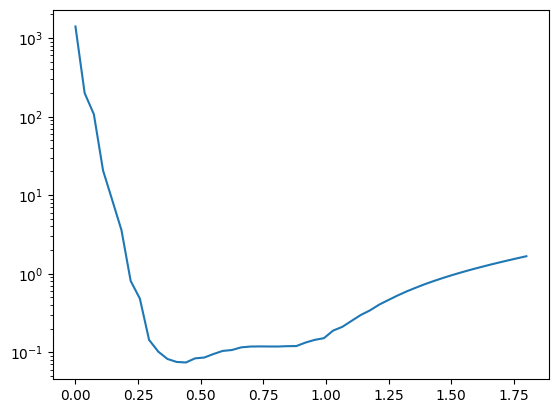

In [8]:
vgs_list = np.linspace(0, 1.8)
vds = 0.2
vbs = 0
gm = db.query_db('gm', 'pch', 1)((vbs, vgs_list, vds))
ids = db.query_db('ids', 'pch', 1)((vbs, vgs_list, vds))
plt.semilogy(vgs_list, 2*ids/gm)